# Time-series prediction of renewable energy production

In [16]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from scipy.signal import savgol_filter

In [2]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)

In [3]:
data = pd.read_csv('../data/generation_2017.csv').set_index('timestamp')

In [14]:
def split_train_test(ds, ratio=2/3):
    train_length = int(ratio * len(ds))
    return ds[:train_length], ds[train_length:]

def create_datasets(ds, lookback=1):
    """
    Create two datasets for training: X = input, Y = output.
    X is three-dimensional: num_samples, lookback_range, num_features.
    Y is two-dimensional: num_samples, num_features. 
    The lookback argument tells us how many samples to scan back.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)


In [18]:
lookback = 5

# select the columns we are interested in to model
model_df = data[['renewables', 'non_renewables']]
dataset = model_df.as_matrix()

# scaling to [0, 1] is essential for LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_ds, test_ds = split_train_test(dataset, 9/10)
train_x, train_y = create_datasets(train_ds, lookback)
test_x, test_y = create_datasets(test_ds, lookback)

In [19]:
model = Sequential()
model.add(LSTM(32, input_shape=(lookback, 2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(train_x, train_y, epochs=50, batch_size=16, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 0.0158
Epoch 2/50
 - 3s - loss: 0.0036
Epoch 3/50
 - 3s - loss: 0.0021
Epoch 4/50
 - 3s - loss: 0.0017
Epoch 5/50
 - 3s - loss: 0.0014
Epoch 6/50
 - 3s - loss: 0.0012
Epoch 7/50
 - 3s - loss: 0.0011
Epoch 8/50
 - 3s - loss: 0.0011
Epoch 9/50
 - 3s - loss: 0.0010
Epoch 10/50
 - 3s - loss: 9.6152e-04
Epoch 11/50
 - 3s - loss: 9.2478e-04
Epoch 12/50
 - 3s - loss: 8.8872e-04
Epoch 13/50
 - 3s - loss: 8.8922e-04
Epoch 14/50
 - 3s - loss: 8.5126e-04
Epoch 15/50
 - 3s - loss: 8.4451e-04
Epoch 16/50
 - 3s - loss: 

In [20]:
train_score = model.evaluate(train_x, train_y, verbose=0)
print(f'Train Score: {train_score:.2} MSE ({math.sqrt(train_score):.2} RMSE)')
test_score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Score: {test_score:.2} MSE ({math.sqrt(test_score):.2} RMSE)')


Train Score: 0.00078 MSE (0.028 RMSE)
Test Score: 0.0011 MSE (0.033 RMSE)


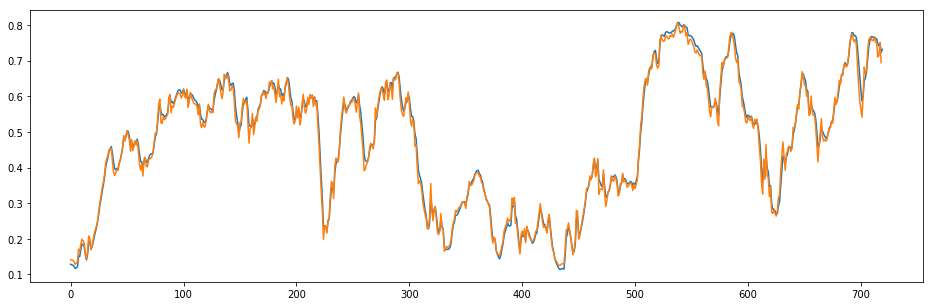

In [21]:
test_predict = model.predict(test_x)
test_predict_mw = scaler.inverse_transform(test_predict)
test_predict_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict_mw]

real = model_df[-720:].apply(pd.Series).reset_index(drop=True)
real['ratio'] = real['renewables'] / (real['renewables'] + real['non_renewables'])

plt.plot(real['ratio'])
plt.plot(test_predict_ratio[-719:])
plt.show()

In [22]:
def extend_prediction(model, x, t=1):
    """Returns X suitable for predicting t+1"""
    rows, lookback, _ = x.shape
    assert t < lookback, "Resulting X must retain at least one non-predicted value"
    x_t = x.copy()
    roll_one = lambda arr: np.roll(arr, -1, axis=1)
    for i in range(1, t + 1):
        p = model.predict(x_t)
        x_t = roll_one(x_t)
        for row in range(rows):
            x_t[row, 2] = p[row]
    return model.predict(x_t)

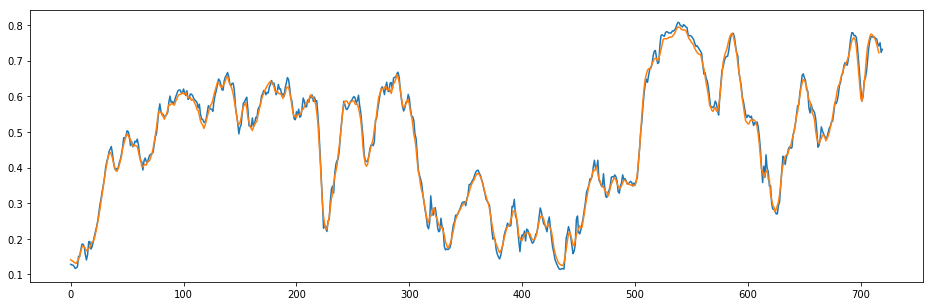

In [23]:
test_predict_t3 = extend_prediction(model, test_x, t = 2)
test_predict_t3_mw = scaler.inverse_transform(test_predict_t3)
test_predict_t3_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict_t3_mw]

plt.plot(real['ratio'])
plt.plot(savgol_filter(test_predict_t3_ratio[-717:], lookback, 1))
plt.show()

* with a lookback of 5, t+3 prediction is still possible
* filter reduces jitter

In [29]:
model.save('model_lstm_32.h5')

### References

* https://keras.io/getting-started/sequential-model-guide/
* https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
